# Digit Classification Project

In [58]:
# Import packages
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torch import nn
import torchvision.models as models

First we can load the MNIST dataset used to train and test the neural network.

In [32]:
# Load training dataset
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

# Load test dataset
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

We can display the first few digits and their labels to get an understanding of the dataset. There are 60,000 images in the training set and 10,000 in the test set. Each image is grayscale with a size of 28x28 pixels.

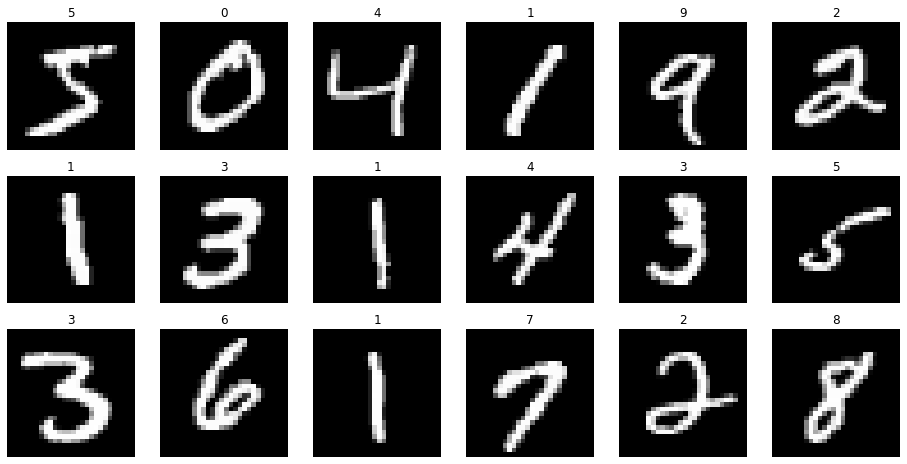

In [57]:
figure = plt.figure(figsize=(16, 8))
cols, rows = 6, 3

# Loop through first few images in the training data
for i in range(1, cols * rows + 1):
    img, label = training_data[i-1]
    # Add subplot containing the image and titled with the correct label
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

The next step is creating a neural network model to train the data. We can create a class for the network and add the layers for training.

In [84]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        """
        Constructor method creates a network to take in the 28x28 sized image and output 10 values for the digits
        """
        super().__init__()
        self.flatten = nn.Flatten()
        # Network layers
        self.linear_relu_stack = nn.Sequential(
            # Linear layer starting with 28x28 image
            nn.Linear(28*28, 512),
            nn.ReLU(),
            # Hidden layer for better learning patterns in data
            nn.Linear(512, 512),
            nn.ReLU(),
            # Final layer to produce outputs for prediction
            nn.Linear(512, 10),
        )

    def forward(self, x):
        """
        Forward pass method
        """
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Now we can set up the parameters of the network to get it ready to take in the training data.

In [165]:
# Initialize neural network
model = NeuralNetwork()

# Hyperparameters
learning_rate = 1e-3
batch_size = 64
epochs = 50

# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

# Initialize optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Split data into batches
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [166]:
def train_loop(dataloader, model, loss_fn, optimizer):
    """
    Takes in the training set and first computes the predictions. It uses the error to perform gradient descent and update
    the weights to improve the model.
    """
    size = len(dataloader.dataset)
    # Set the model to training mode
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Print current loss
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [167]:
def test_loop(dataloader, model, loss_fn):
    """
    Takes in the test set and computes predictions. It then prints the accuracy of the model.
    """
    # Set to test mode
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Makes sure gradients are not computed
    with torch.no_grad():
        for X, y in dataloader:
            # Makes predictions and determines the accuracy
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return np.round(100*correct, 1), np.round(test_loss, 6)

Finally we can pass in the training data and train the model. We can see how the model improves with each epoch.

In [168]:
test_acc, test_loss = test_loop(test_dataloader, model, loss_fn)
accuracy_list, loss_list = [test_acc], [test_loss]
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_acc, test_loss = test_loop(test_dataloader, model, loss_fn)
    accuracy_list.append(test_acc)
    loss_list.append(test_loss)
print("Finished training")

Test Error: 
 Accuracy: 10.9%, Avg loss: 2.301513 

Epoch 1
-------------------------------
loss: 2.302296  [   64/60000]
loss: 2.294717  [ 6464/60000]
loss: 2.287603  [12864/60000]
loss: 2.288479  [19264/60000]
loss: 2.282953  [25664/60000]
loss: 2.283276  [32064/60000]
loss: 2.267616  [38464/60000]
loss: 2.274707  [44864/60000]
loss: 2.261990  [51264/60000]
loss: 2.253134  [57664/60000]
Test Error: 
 Accuracy: 54.8%, Avg loss: 2.253756 

Epoch 2
-------------------------------
loss: 2.253281  [   64/60000]
loss: 2.245225  [ 6464/60000]
loss: 2.247971  [12864/60000]
loss: 2.226567  [19264/60000]
loss: 2.227113  [25664/60000]
loss: 2.228101  [32064/60000]
loss: 2.204064  [38464/60000]
loss: 2.228725  [44864/60000]
loss: 2.197639  [51264/60000]
loss: 2.186362  [57664/60000]
Test Error: 
 Accuracy: 68.1%, Avg loss: 2.183964 

Epoch 3
-------------------------------
loss: 2.181638  [   64/60000]
loss: 2.169678  [ 6464/60000]
loss: 2.184881  [12864/60000]
loss: 2.130471  [19264/60000]
loss

loss: 0.479841  [57664/60000]
Test Error: 
 Accuracy: 89.7%, Avg loss: 0.375107 

Epoch 22
-------------------------------
loss: 0.394577  [   64/60000]
loss: 0.322360  [ 6464/60000]
loss: 0.345721  [12864/60000]
loss: 0.418748  [19264/60000]
loss: 0.327813  [25664/60000]
loss: 0.388707  [32064/60000]
loss: 0.275031  [38464/60000]
loss: 0.475224  [44864/60000]
loss: 0.412199  [51264/60000]
loss: 0.475224  [57664/60000]
Test Error: 
 Accuracy: 89.9%, Avg loss: 0.367320 

Epoch 23
-------------------------------
loss: 0.382079  [   64/60000]
loss: 0.315633  [ 6464/60000]
loss: 0.334572  [12864/60000]
loss: 0.412523  [19264/60000]
loss: 0.318487  [25664/60000]
loss: 0.383167  [32064/60000]
loss: 0.267434  [38464/60000]
loss: 0.467737  [44864/60000]
loss: 0.403753  [51264/60000]
loss: 0.471056  [57664/60000]
Test Error: 
 Accuracy: 89.9%, Avg loss: 0.360329 

Epoch 24
-------------------------------
loss: 0.370642  [   64/60000]
loss: 0.309814  [ 6464/60000]
loss: 0.324279  [12864/60000]
l

loss: 0.385718  [44864/60000]
loss: 0.305177  [51264/60000]
loss: 0.415638  [57664/60000]
Test Error: 
 Accuracy: 91.7%, Avg loss: 0.290372 

Epoch 43
-------------------------------
loss: 0.246651  [   64/60000]
loss: 0.262035  [ 6464/60000]
loss: 0.216803  [12864/60000]
loss: 0.346556  [19264/60000]
loss: 0.225669  [25664/60000]
loss: 0.317645  [32064/60000]
loss: 0.195345  [38464/60000]
loss: 0.383026  [44864/60000]
loss: 0.301319  [51264/60000]
loss: 0.413101  [57664/60000]
Test Error: 
 Accuracy: 91.7%, Avg loss: 0.288104 

Epoch 44
-------------------------------
loss: 0.242559  [   64/60000]
loss: 0.260566  [ 6464/60000]
loss: 0.213625  [12864/60000]
loss: 0.344396  [19264/60000]
loss: 0.222908  [25664/60000]
loss: 0.315507  [32064/60000]
loss: 0.193496  [38464/60000]
loss: 0.380441  [44864/60000]
loss: 0.297544  [51264/60000]
loss: 0.410629  [57664/60000]
Test Error: 
 Accuracy: 91.8%, Avg loss: 0.285900 

Epoch 45
-------------------------------
loss: 0.238580  [   64/60000]
l

We can visualize how the model improves as it trains on the data across multiple epochs.

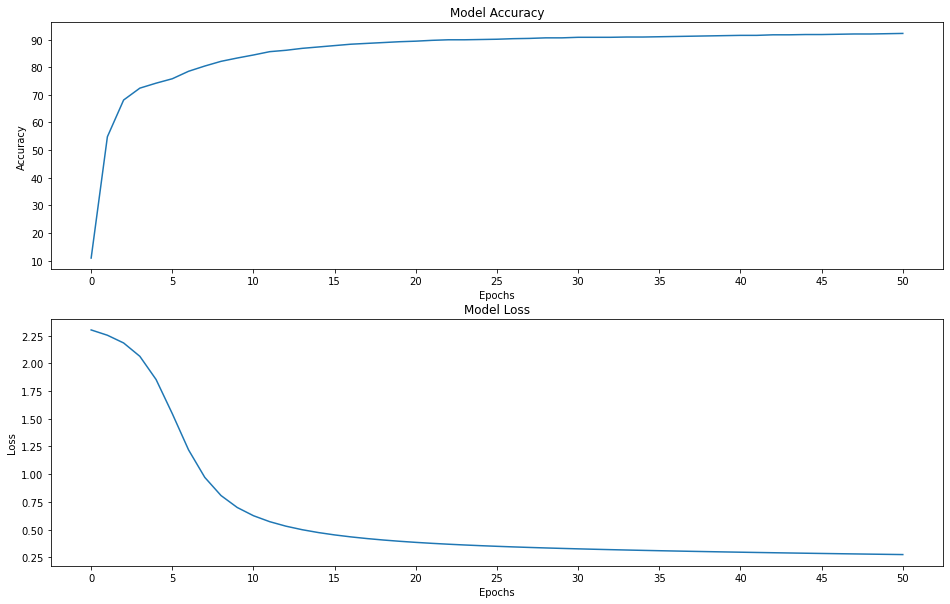

In [169]:
fig = plt.figure(figsize=(16, 10))
fig.add_subplot(2, 1, 1)
plt.plot(np.arange(0,epochs+1), accuracy_list)
plt.xticks(np.arange(0,epochs+1, 5))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
fig.add_subplot(2, 1, 2)
plt.plot(np.arange(0,epochs+1), loss_list)
plt.xticks(np.arange(0,epochs+1, 5))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.show()

We can also see a few of the incorrect predictions to see where the model is guessing wrong.

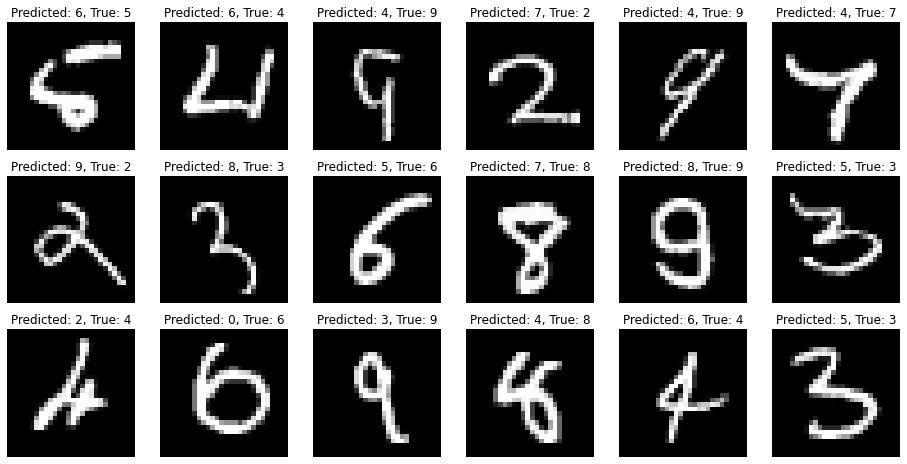

In [170]:
model.eval()
figure = plt.figure(figsize=(16, 8))
cols, rows = 6, 3
total_incorrect = 0
for img in test_data:
    pred = model(img[0]).argmax(1).item()
    if pred != img[1]:
        total_incorrect += 1
        figure.add_subplot(rows, cols, total_incorrect)
        plt.title(f'Predicted: {pred}, True: {img[1]}')
        plt.axis("off")
        plt.imshow(img[0].squeeze(), cmap="gray")
    if total_incorrect >= rows*cols:
        break

In [171]:
torch.save(model, 'model.pth')